In [1]:

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import FloatSlider, RadioButtons, VBox, HBox, Output
from IPython.display import display


signal_data_by_mass = {}
for file in os.listdir():
    if file.startswith("DM_") and file.endswith(".csv"):
        mass_str = file.split("_")[1].replace(".csv", "")
        try:
            mass = int(mass_str)
            signal_data_by_mass[mass] = pd.read_csv(file)
        except ValueError:
            continue


background_data = {}
background_labels = ["WZ", "ZZ", "Z+jets", "Non-resonant_ll"]
for label in background_labels:
    for file in os.listdir():
        if file.startswith(label) and file.endswith(".csv"):
            background_data[label] = pd.read_csv(file)


def interactive_histogram(variable):
    output = Output()
    
    etmiss_min_slider = FloatSlider(value=0, min=0, max=1700, step=50, description="Min ETmiss")
    etmiss_max_slider = FloatSlider(value=1750, min=50, max=1750, step=50, description="Max ETmiss")
    bjet_radio = RadioButtons(options=['0', '1', '2'], description="Bjets", layout={"width": "150px"})

    def update(*args):
        with output:
            output.clear_output()
            plt.figure(figsize=(10, 6))
            
            
            for label in background_labels:
                df = background_data.get(label)
                if df is not None:
                    df_cut = df[
                        (df['ETmiss'] >= etmiss_min_slider.value) &
                        (df['ETmiss'] <= etmiss_max_slider.value) &
                        (df['N_bjets'] == int(bjet_radio.value))
                    ]
                    weights = df_cut['totalWeight']
                    plt.hist(df_cut[variable], bins=40, weights=weights,
                             label=f"Background: {label}", alpha=0.4)

            
            for mass in sorted(signal_data_by_mass.keys(), reverse=True):
                df = signal_data_by_mass[mass]
                df_cut = df[
                    (df['ETmiss'] >= etmiss_min_slider.value) &
                    (df['ETmiss'] <= etmiss_max_slider.value) &
                    (df['N_bjets'] == int(bjet_radio.value))
                ]
                weights = df_cut['totalWeight']
                plt.hist(df_cut[variable], bins=40, weights=weights,
                         label=f"Signal {mass} GeV", histtype="step", linewidth=2)

            plt.xlabel(variable)
            plt.ylabel("Weighted Events")
            plt.title(f"{variable} with ETmiss ∈ [{etmiss_min_slider.value}, {etmiss_max_slider.value}] and {bjet_radio.value} b-jets")
            plt.legend(loc="upper right")
            plt.grid(True)
            plt.show()

    
    etmiss_min_slider.observe(update, names="value")
    etmiss_max_slider.observe(update, names="value")
    bjet_radio.observe(update, names="value")
    
    
    ui = HBox([VBox([etmiss_min_slider, etmiss_max_slider]), bjet_radio])
    display(ui, output)

    
    update()


In [2]:
import numpy as np
import matplotlib.pyplot as plt

def plot_significance_vs_etmiss_cut(signal_data_by_mass, background_data, bjets_required=0):
    etmiss_cut_values = np.arange(0, 1000, 50)  # ETmiss min cut values
    bins = np.linspace(0, 1000, 40)  # Fixed ETmiss histogram bins

    # Prepare background summed once (not per cut)
    background_histograms = []
    for label, df in background_data.items():
        df_bkg = df[df["N_bjets"] == bjets_required]
        weights = df_bkg["totalWeight"]
        hist, _ = np.histogram(df_bkg["ETmiss"], bins=bins, weights=weights)
        background_histograms.append(hist)
    total_background_hist = np.sum(background_histograms, axis=0)

    # Center of bins for plotting
    bin_centers = 0.5 * (bins[1:] + bins[:-1])

    # Store peak significance at each cut per signal
    significance_curves = {}

    for mass, df_signal in sorted(signal_data_by_mass.items()):
        df_sig = df_signal[df_signal["N_bjets"] == bjets_required]
        weights = df_sig["totalWeight"]
        sig_hist_full, _ = np.histogram(df_sig["ETmiss"], bins=bins, weights=weights)

        peak_significances = []
        for cut in etmiss_cut_values:
            cut_mask = bin_centers >= cut
            s = sig_hist_full[cut_mask]
            b = total_background_hist[cut_mask]

            with np.errstate(divide='ignore', invalid='ignore'):
                sig_vals = np.where(s + b > 0, s / np.sqrt(s + b), 0)
            peak = np.max(sig_vals) if len(sig_vals) > 0 else 0
            peak_significances.append(peak)

        significance_curves[mass] = peak_significances

    # === Plotting ===
    plt.figure(figsize=(10, 6))
    for mass, peaks in significance_curves.items():
        plt.plot(etmiss_cut_values, peaks, marker='o', label=f"DM {mass} GeV")

    plt.xlabel("ETmiss Cut Threshold (GeV)")
    plt.ylabel("Peak S / √(S + B)")
    plt.title("Peak Significance vs. ETmiss Cut")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


In [3]:
import numpy as np
import matplotlib.pyplot as plt

def compute_significance(S, B):
    return S / np.sqrt(S + B) if (S + B) > 0 else 0

def plot_significance_curve_and_heatmaps(signal_data_by_mass, background_data, bjets_required=0):
    etmiss_min_values = np.arange(0, 1750, 50)
    etmiss_max_values = np.arange(100, 1800, 50)

    fig_curve, ax_curve = plt.subplots(figsize=(12, 6))
    fig_curve.suptitle("Significance vs ETmiss Cut (Max=1750)")

    num_masses = len(signal_data_by_mass)
    fig_heatmaps, axs_heatmaps = plt.subplots(
        nrows=num_masses, figsize=(10, 5 * num_masses), constrained_layout=True
    )
    if num_masses == 1:
        axs_heatmaps = [axs_heatmaps]

    for idx, (mass, signal_df) in enumerate(sorted(signal_data_by_mass.items())):
        signal_df = signal_df[signal_df["N_bjets"] == bjets_required]

        signal_curve = []
        best_sig = 0
        best_cut = None
        heatmap = np.zeros((len(etmiss_min_values), len(etmiss_max_values)))

        for i_min, etmin in enumerate(etmiss_min_values):
            for i_max, etmax in enumerate(etmiss_max_values):
                if etmin >= etmax:
                    heatmap[i_min, i_max] = np.nan
                    continue

                sig_cut = signal_df[(signal_df["ETmiss"] >= etmin) & (signal_df["ETmiss"] <= etmax)]
                S = sig_cut["totalWeight"].sum()

                B = 0
                for bg_df in background_data.values():
                    bg_cut = bg_df[
                        (bg_df["N_bjets"] == bjets_required) &
                        (bg_df["ETmiss"] >= etmin) &
                        (bg_df["ETmiss"] <= etmax)
                    ]
                    B += bg_cut["totalWeight"].sum()

                significance = compute_significance(S, B)
                heatmap[i_min, i_max] = significance

                # For 1D curve: use fixed max cut
                if etmax == 1750:
                    signal_curve.append((etmin, significance))
                    if significance > best_sig:
                        best_sig = significance
                        best_cut = etmin

        # Plot 1D curve
        if signal_curve:
            et_vals, sig_vals = zip(*signal_curve)
            ax_curve.plot(et_vals, sig_vals, label=f"{mass} GeV")
            if best_cut is not None:
                ax_curve.axvline(best_cut, color=ax_curve.lines[-1].get_color(), linestyle='--')
                ax_curve.text(best_cut + 10, max(sig_vals) * 0.8, f"Peak: {best_cut}", rotation=90)

        # Plot heatmap
        ax = axs_heatmaps[idx]
        im = ax.imshow(
            heatmap,
            origin="lower",
            extent=[etmiss_max_values[0], etmiss_max_values[-1], etmiss_min_values[0], etmiss_min_values[-1]],
            aspect="auto",
            cmap="viridis"
        )
        ax.set_title(f"Significance Heatmap for DM {mass} GeV")
        ax.set_xlabel("ETmiss max")
        ax.set_ylabel("ETmiss min")
        fig_heatmaps.colorbar(im, ax=ax, label="S / sqrt(S + B)")

    ax_curve.set_xlabel("ETmiss min cut")
    ax_curve.set_ylabel("Significance")
    ax_curve.legend()
    ax_curve.grid(True)
    plt.show()


In [4]:
import numpy as np
import matplotlib.pyplot as plt

def compute_significance(S, B):
    return S / np.sqrt(S + B) if (S + B) > 0 else 0

def plot_significance_heatmaps(signal_data_by_mass, background_data, bjets_required=0):
    etmiss_min_values = np.arange(0, 1750, 50)
    etmiss_max_values = np.arange(100, 1800, 50)

    num_masses = len(signal_data_by_mass)
    fig_heatmaps, axs_heatmaps = plt.subplots(
        nrows=num_masses, figsize=(10, 5 * num_masses), constrained_layout=True
    )
    if num_masses == 1:
        axs_heatmaps = [axs_heatmaps]

    for idx, (mass, signal_df) in enumerate(sorted(signal_data_by_mass.items())):
        signal_df = signal_df[signal_df["N_bjets"] == bjets_required]

        heatmap = np.zeros((len(etmiss_min_values), len(etmiss_max_values)))
        best_sig = 0
        best_coords = None

        for i_min, etmin in enumerate(etmiss_min_values):
            for i_max, etmax in enumerate(etmiss_max_values):
                if etmin >= etmax:
                    heatmap[i_min, i_max] = np.nan
                    continue

                sig_cut = signal_df[(signal_df["ETmiss"] >= etmin) & (signal_df["ETmiss"] <= etmax)]
                S = sig_cut["totalWeight"].sum()

                B = 0
                for bg_df in background_data.values():
                    bg_cut = bg_df[
                        (bg_df["N_bjets"] == bjets_required) &
                        (bg_df["ETmiss"] >= etmin) &
                        (bg_df["ETmiss"] <= etmax)
                    ]
                    B += bg_cut["totalWeight"].sum()

                significance = compute_significance(S, B)
                heatmap[i_min, i_max] = significance

                if significance > best_sig:
                    best_sig = significance
                    best_coords = (etmin, etmax)

        ax = axs_heatmaps[idx]
        im = ax.imshow(
            heatmap,
            origin="lower",
            extent=[etmiss_max_values[0], etmiss_max_values[-1], etmiss_min_values[0], etmiss_min_values[-1]],
            aspect="auto",
            cmap="viridis"
        )
        ax.set_title(f"Significance Heatmap for DM {mass} GeV\nPeak: {best_sig:.3f} at min={best_coords[0]}, max={best_coords[1]}")
        ax.set_xlabel("ETmiss max")
        ax.set_ylabel("ETmiss min")
        fig_heatmaps.colorbar(im, ax=ax, label="S / sqrt(S + B)")

    plt.show()


Output()

Output()

Output()

Output()

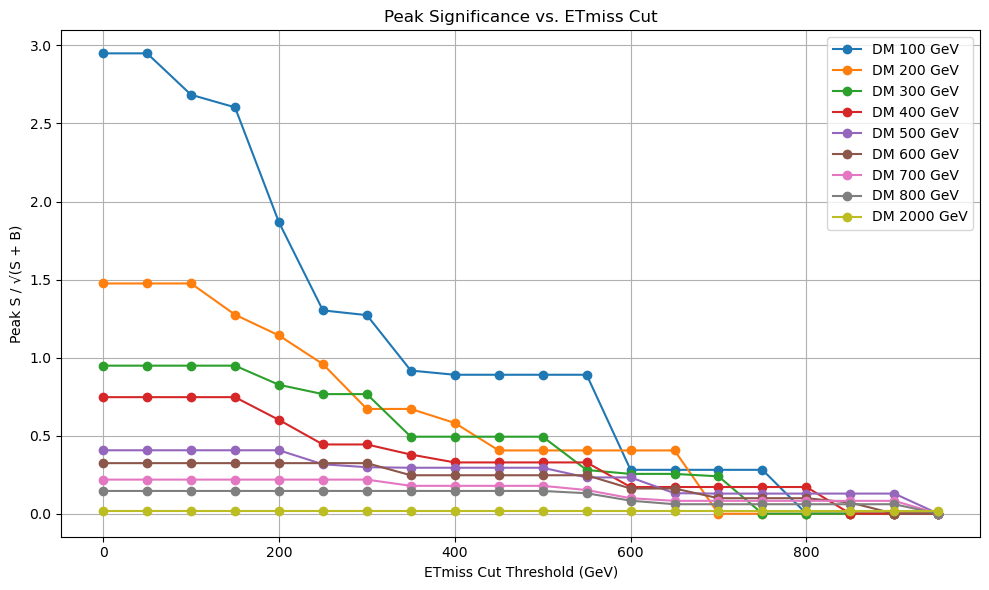

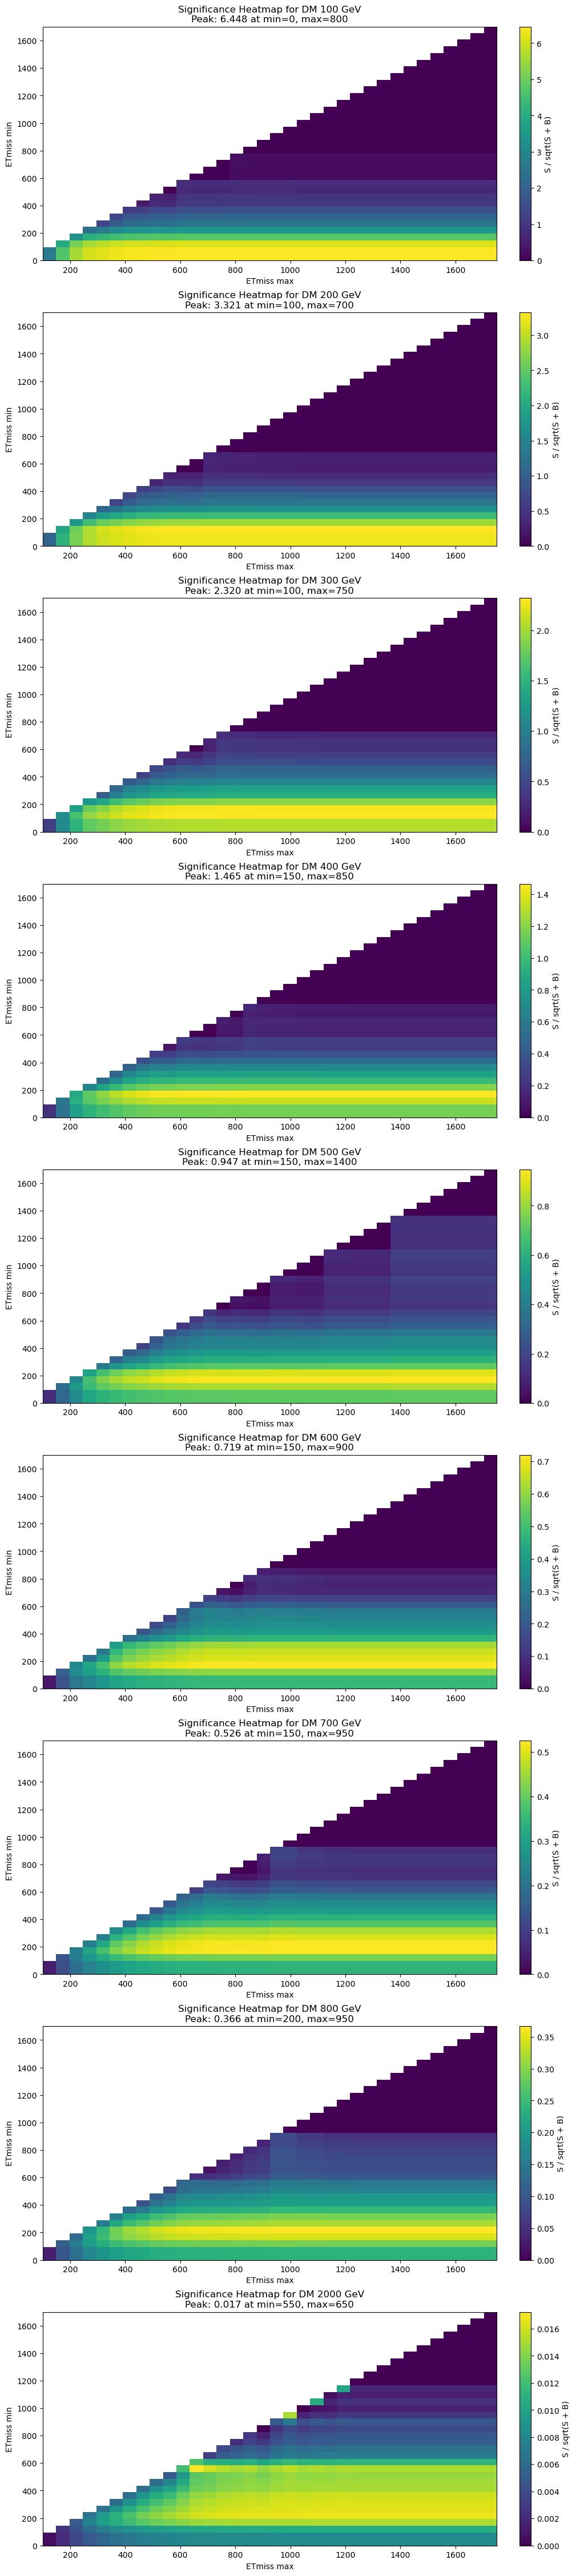

In [5]:
interactive_histogram("ETmiss")
interactive_histogram("mll")
interactive_histogram("lead_lep_pt")
interactive_histogram("dRll")
plot_significance_vs_etmiss_cut(signal_data_by_mass, background_data, bjets_required=0)
plot_significance_heatmaps(signal_data_by_mass, background_data, bjets_required=0)